In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from ta.trend import MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands
from ta.momentum import StochasticOscillator
from ta.trend import EMAIndicator
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Pakai python versi 3.12 kalo mau run karena python versi 3.13 engga bisa import tensorflow (Serius gw engga boong)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint




In [2]:
# Download data
ticker = "AAPL"
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
df = yf.download(ticker, start=start_date, end=end_date)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.796021,72.856613,71.545387,71.799873,135480400
2020-01-03,72.088310,72.851776,71.862907,72.020447,146322800
2020-01-06,72.662720,72.701500,70.954010,71.206077,118387200
2020-01-07,72.320969,72.929314,72.100410,72.672402,108872000
2020-01-08,73.484344,73.787308,72.022850,72.022850,132079200


In [3]:
df.reset_index(inplace=True)
# df.drop(columns=['Date'], inplace=True)
df.columns = df.columns.droplevel('Ticker')
df.columns.name = None 
df.head()

,Date,Close,High,Low,Open,Volume
0,2020-01-02,72.796021,72.856613,71.545387,71.799873,135480400
1,2020-01-03,72.088310,72.851776,71.862907,72.020447,146322800
2,2020-01-06,72.662720,72.701500,70.954010,71.206077,118387200
3,2020-01-07,72.320969,72.929314,72.100410,72.672402,108872000
4,2020-01-08,73.484344,73.787308,72.022850,72.022850,132079200


In [4]:
# df.drop(columns=['High', 'Low', 'Open'], inplace=True)
# df.head()


In [5]:
MA100 = df['Close'].rolling(window=100).mean()
MA200 = df['Close'].rolling(window=200).mean()
MA50 = df['Close'].rolling(window=50).mean()



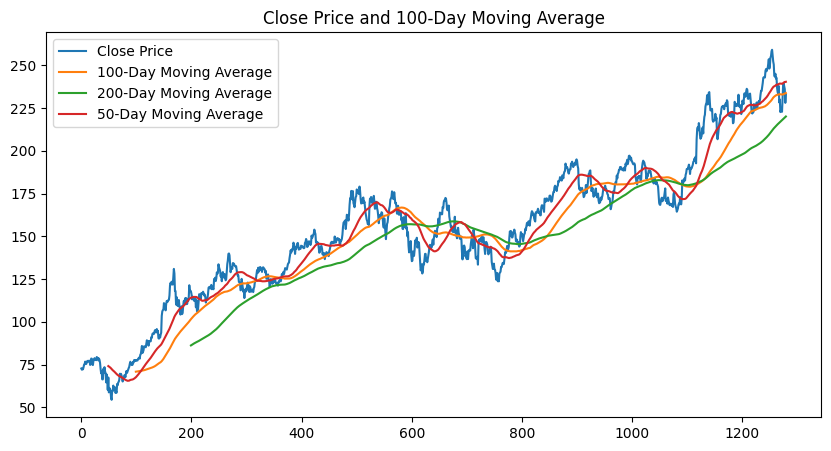

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price')
plt.plot(MA100, label='100-Day Moving Average')
plt.plot(MA200, label='200-Day Moving Average')
plt.plot(MA50, label='50-Day Moving Average')
plt.title('Close Price and 100-Day Moving Average')
plt.legend()
plt.show()


In [7]:
 # RSI
df['RSI'] = RSIIndicator(close=df['Close']).rsi()
 # MACD
macd = MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
df.head()
    

,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal
0,2020-01-02,72.796021,72.856613,71.545387,71.799873,135480400,NaN,NaN,NaN
1,2020-01-03,72.088310,72.851776,71.862907,72.020447,146322800,NaN,NaN,NaN
2,2020-01-06,72.662720,72.701500,70.954010,71.206077,118387200,NaN,NaN,NaN
3,2020-01-07,72.320969,72.929314,72.100410,72.672402,108872000,NaN,NaN,NaN
4,2020-01-08,73.484344,73.787308,72.022850,72.022850,132079200,NaN,NaN,NaN


In [8]:
df.dropna(inplace=True)
df.head()

,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal
33,2020-02-20,77.815559,78.872375,77.307803,78.381627,100566000,53.041440,0.845651,0.952823
34,2020-02-21,76.054207,77.852012,75.434698,77.407417,129554000,46.139601,0.627408,0.887740
35,2020-02-24,72.441582,73.899257,70.267221,72.218076,222195200,35.838925,0.161083,0.742408
36,2020-02-25,69.987854,73.498425,69.514114,73.114574,230673600,30.808042,-0.401845,0.513558
37,2020-02-26,71.098114,72.368724,69.603998,69.611286,198054800,35.237932,-0.749739,0.260898


In [9]:
# Membuat fungsi untuk menghasilkan sinyal trading
def generate_trading_signals(df):
    # Inisialisasi kolom sinyal
    df['Signal'] = 'Hold'
    
    # Membuat sinyal berdasarkan RSI
    df.loc[df['RSI'] < 30, 'RSI_Signal'] = 'Buy'
    df.loc[df['RSI'] > 70, 'RSI_Signal'] = 'Sell'
    df.loc[(df['RSI'] >= 30) & (df['RSI'] <= 70), 'RSI_Signal'] = 'Hold'
    
    # Menyimpan MACD Signal Line original
    df['MACD_Signal_Line'] = df['MACD_Signal']  # Menyimpan garis sinyal MACD asli
    
    # Membuat sinyal berdasarkan MACD
    df['MACD_Cross'] = np.where(df['MACD'] > df['MACD_Signal_Line'], 1, -1)
    df['MACD_Signal_Change'] = df['MACD_Cross'].diff()
    
    df.loc[df['MACD_Signal_Change'] > 0, 'MACD_Signal'] = 'Buy'
    df.loc[df['MACD_Signal_Change'] < 0, 'MACD_Signal'] = 'Sell'
    df.loc[df['MACD_Signal_Change'] == 0, 'MACD_Signal'] = 'Hold'
    
    # Kombinasi sinyal RSI dan MACD
    conditions = [
        # Strong Buy: RSI oversold dan MACD memberikan sinyal beli
        (df['RSI_Signal'] == 'Buy') & (df['MACD_Signal'] == 'Buy'),
        # Strong Sell: RSI overbought dan MACD memberikan sinyal jual
        (df['RSI_Signal'] == 'Sell') & (df['MACD_Signal'] == 'Sell'),
        # Buy: Salah satu indikator memberikan sinyal beli
        ((df['RSI_Signal'] == 'Buy') & (df['MACD_Signal'] == 'Hold')) |
        ((df['RSI_Signal'] == 'Hold') & (df['MACD_Signal'] == 'Buy')),
        # Sell: Salah satu indikator memberikan sinyal jual
        ((df['RSI_Signal'] == 'Sell') & (df['MACD_Signal'] == 'Hold')) |
        ((df['RSI_Signal'] == 'Hold') & (df['MACD_Signal'] == 'Sell'))
    ]
    
    choices = ['Strong Buy', 'Strong Sell', 'Buy', 'Sell']
    df['Signal'] = np.select(conditions, choices, default='Hold')
    
    return df

# Manggil fungsi yag ada diats
df = generate_trading_signals(df)


C:\Users\user\AppData\Local\Temp\ipykernel_9252\3222069365.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Buy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['MACD_Signal_Change'] > 0, 'MACD_Signal'] = 'Buy'


In [10]:
# Fungsi untuk menambahkan indikator teknikal
def add_technical_indicators(df):
    
    # Bollinger Bands
    bb = BollingerBands(df['Close'])
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_middle'] = bb.bollinger_mavg()
    df['BB_lower'] = bb.bollinger_lband()
    
    # Stochastic Oscillator
    stoch = StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()
    
    # EMA
    ema20 = EMAIndicator(df['Close'], window=20)
    ema50 = EMAIndicator(df['Close'], window=50)
    df['EMA20'] = ema20.ema_indicator()
    df['EMA50'] = ema50.ema_indicator()
    
    return df

# Manggil fungsi yang ada diatas
df = add_technical_indicators(df)


In [11]:
df.dropna(inplace=True)
df.head()


,Date,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,Signal,...,MACD_Signal_Line,MACD_Cross,MACD_Signal_Change,BB_upper,BB_middle,BB_lower,Stoch_K,Stoch_D,EMA20,EMA50
82,2020-04-30,71.377487,71.554840,70.053437,70.444576,183064000,60.569600,1.344508,Hold,Hold,...,0.820555,1,0.0,73.149587,66.557443,59.965298,97.491371,84.644501,67.114489,67.492599
83,2020-05-01,70.228348,72.640798,69.446062,69.543239,240616800,57.545327,1.412641,Hold,Hold,...,0.938972,1,0.0,73.014211,67.093624,61.173036,70.420001,86.714009,67.411047,67.599884
84,2020-05-04,71.222008,71.350769,69.560259,70.252656,133568000,59.431597,1.529190,Hold,Hold,...,1.057016,1,0.0,72.478393,67.722247,62.966100,82.603657,83.505010,67.773996,67.741928
85,2020-05-05,72.290955,73.126689,71.537821,71.683590,147751200,61.417561,1.688349,Hold,Hold,...,1.183282,1,0.0,72.937902,68.148494,63.359086,90.328909,81.117522,68.204182,67.920321
86,2020-05-06,73.036804,73.670889,72.609217,72.995500,142333600,62.786438,1.853303,Hold,Hold,...,1.317286,1,0.0,73.282604,68.648962,64.015321,93.097096,88.676554,68.664432,68.120967


In [12]:
df["MACD_Signal"].value_counts()

MACD_Signal
Hold    1108
Sell      45
Buy       45
Name: count, dtype: int64

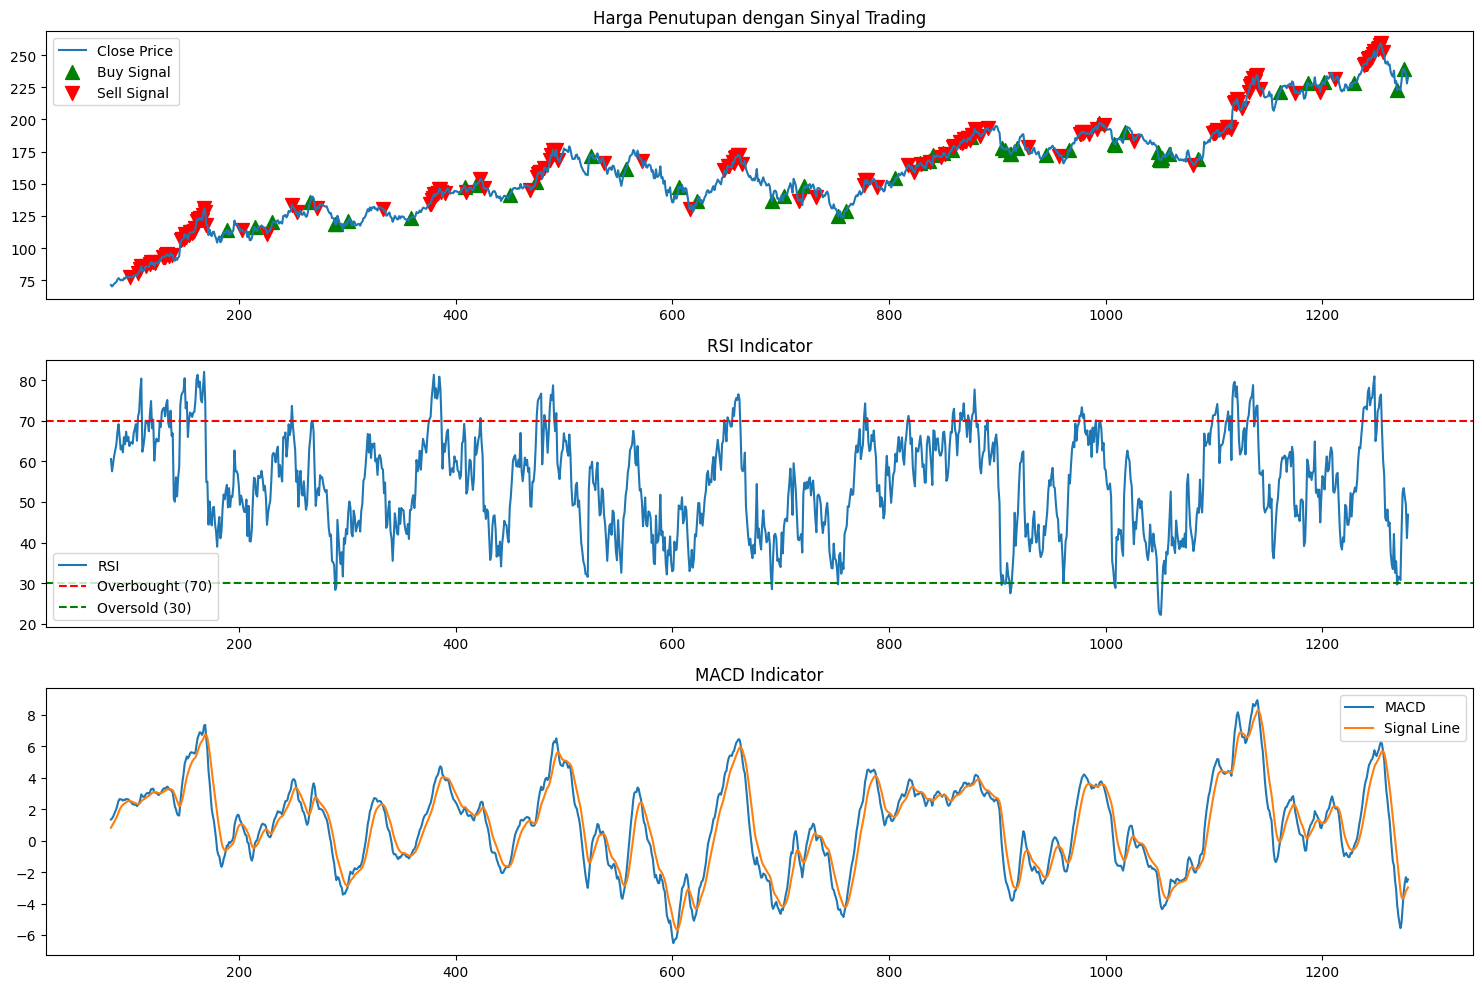

In [ ]:
# Visualisasi
plt.figure(figsize=(15, 10))

# Plot close price
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Close'], label='Close Price')
plt.title('Harga Penutupan dengan Sinyal Trading')

# Menambahkan marker untuk sinyal
buy_signals = df[df['Signal'].isin(['Buy', 'Strong Buy'])]
sell_signals = df[df['Signal'].isin(['Sell', 'Strong Sell'])]

plt.scatter(buy_signals.index, buy_signals['Close'], 
           marker='^', color='g', label='Buy Signal', s=100)
plt.scatter(sell_signals.index, sell_signals['Close'], 
           marker='v', color='r', label='Sell Signal', s=100)
plt.legend()

# Plot RSI
plt.subplot(3, 1, 2)
plt.plot(df.index, df['RSI'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.title('RSI Indicator')
plt.legend()

# Plot MACD
plt.subplot(3, 1, 3)
plt.plot(df.index, df['MACD'], label='MACD')
plt.plot(df.index, df['MACD_Signal_Line'], label='Signal Line')  
plt.title('MACD Indicator')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
print("\nStatistik Sinyal Trading:")
print(df['Signal'].value_counts())

print("\nSinyal Trading Terakhir:")
print(df[['Close', 'RSI', 'MACD', 'MACD_Signal_Line', 'Signal']].tail())


Statistik Sinyal Trading:
Signal
Hold    973
Sell    173
Buy      52
Name: count, dtype: int64

Sinyal Trading Terakhir:
           Close        RSI      MACD  MACD_Signal_Line Signal
1275  239.360001  53.425076 -3.320554         -3.634534    Buy
1276  237.589996  51.292713 -2.707687         -3.449165   Hold
1277  236.000000  49.385827 -2.323502         -3.224032   Hold
1278  228.009995  41.114110 -2.633402         -3.105906   Hold
1279  232.800003  46.860376 -2.464083         -2.977541   Hold


## Membuat Signal Trading 

In [15]:
# Persiapkan fitur (X) dan target (y) dimana kita fokus pake 2 indikator RSI sama MACD (biar lebih simple wkkwkw)
features = ['Close', 'RSI', 'MACD', 'MACD_Signal_Line']
X1 = df[features]
y1 = df['Signal']

# Konversi label kategorikal ke numerik
y1 = y1.map({'Buy': 1, 'Strong Buy': 1, 'Sell': 2, 'Strong Sell': 2, 'Hold': 0})

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [16]:
# Normalisasi data
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)


In [17]:
# 1. Model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X1_train_scaled, y1_train)


RandomForestClassifier(random_state=42)

In [18]:
# Evaluasi model Random Forest
rf_predictions = rf_model.predict(X1_test_scaled)
print("\nHasil Evaluasi Model Random Forest:")
print(classification_report(y1_test, rf_predictions, target_names=['Hold', 'Buy', 'Sell']))



Hasil Evaluasi Model Random Forest:
              precision    recall  f1-score   support

        Hold       0.90      0.99      0.94       193
         Buy       1.00      0.33      0.50        12
        Sell       0.95      0.60      0.74        35

    accuracy                           0.90       240
   macro avg       0.95      0.64      0.73       240
weighted avg       0.91      0.90      0.89       240



In [19]:
# 2. Model Deep Learning (LSTM)

X1_train_lstm = X1_train_scaled.reshape((X1_train_scaled.shape[0], 1, X1_train_scaled.shape[1]))
X1_test_lstm = X1_test_scaled.reshape((X1_test_scaled.shape[0], 1, X1_test_scaled.shape[1]))

# Buat model LSTM
lstm_model = Sequential([
    LSTM(50, input_shape=(1, len(features)), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 kelas: Hold, Buy, Sell
])

# Compile model
lstm_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Training model
history = lstm_model.fit(X1_train_lstm, y1_train,
                        epochs=50,
                        batch_size=32,
                        validation_split=0.2,
                        verbose=1)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.6453 - loss: 1.0761 - val_accuracy: 0.8177 - val_loss: 0.9880
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8034 - loss: 0.9449 - val_accuracy: 0.8177 - val_loss: 0.7805
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8069 - loss: 0.7082 - val_accuracy: 0.8177 - val_loss: 0.5517
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8120 - loss: 0.5309 - val_accuracy: 0.8177 - val_loss: 0.4900
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8438 - loss: 0.4421 - val_accuracy: 0.8698 - val_loss: 0.4586
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8526 - loss: 0.4762 - val_accuracy: 0.8802 - val_loss: 0.4389
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8876 - loss: 0.3885 - val_accuracy: 0.8802 - val_loss: 0.4333
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8799 - loss: 0.4017 - val_accuracy: 0.9010 - 

In [20]:
train_accuracy = history.history['accuracy'][-1]  # Final training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Final validation accuracy
train_loss = history.history['loss'][-1]  # Final training loss
val_loss = history.history['val_loss'][-1]  # Final validation loss

# 2. Prediksi
y_pred_lstm = lstm_model.predict(X1_test_lstm)
y_pred_classes = np.argmax(y_pred_lstm, axis=1)



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step



LSTM Model Evaluation:
Final Training Accuracy: 0.9086
Final Validation Accuracy: 0.8906
Final Training Loss: 0.3165
Final Validation Loss: 0.3858

Detailed Classification Report:
              precision    recall  f1-score   support

        Hold       0.88      0.98      0.93       193
         Buy       0.00      0.00      0.00        12
        Sell       0.87      0.57      0.69        35

    accuracy                           0.88       240
   macro avg       0.58      0.52      0.54       240
weighted avg       0.83      0.88      0.85       240



c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

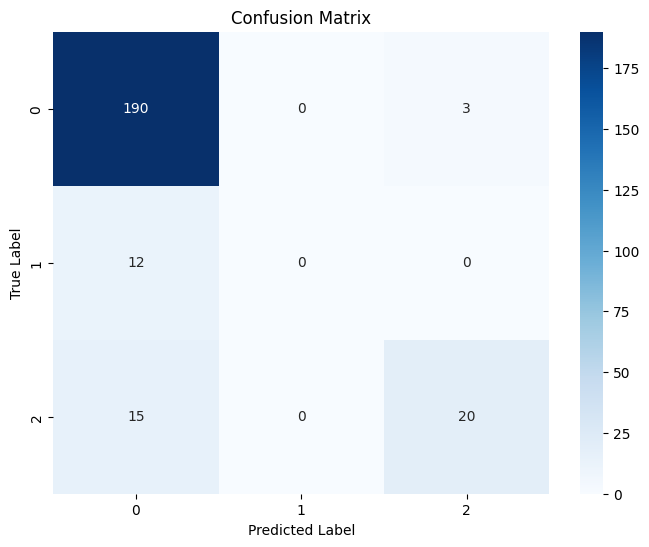

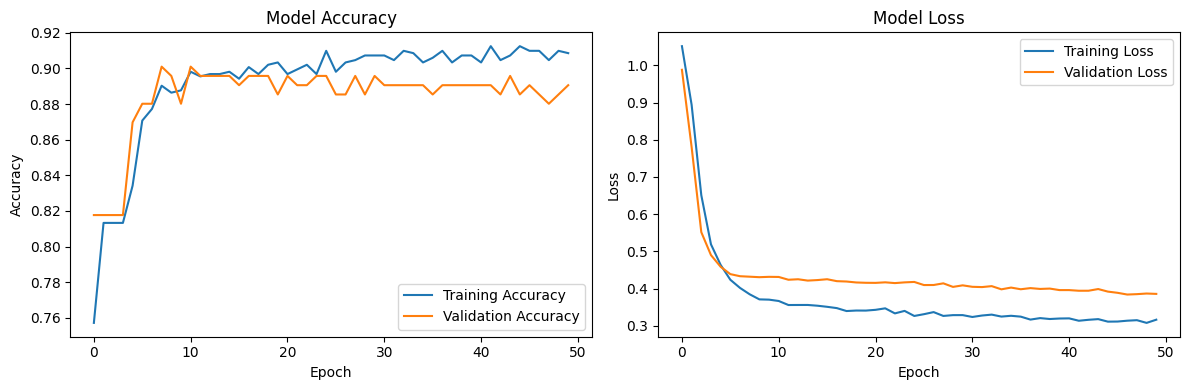

In [21]:
# 3. Evaluasi Model LSTM
from sklearn.metrics import classification_report, confusion_matrix
print("\nLSTM Model Evaluation:")
print(f"Final Training Accuracy: {train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y1_test, y_pred_classes, target_names=['Hold', 'Buy', 'Sell']))

# 4. Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y1_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Prediksi Harga Saham

In [22]:
features2 = [
    'Close', 'RSI', 'MACD', 'MACD_Signal_Line',
    'BB_upper', 'BB_lower', 'BB_middle',
    'Stoch_K', 'Stoch_D', 'EMA20', 'EMA50'
]

In [23]:
def prepare_price_prediction_data(df, features, lookback=60):  
    # Preprocessing 
    price_scaler = RobustScaler()  
    feature_scaler = RobustScaler()
    
     
    df_clean = df[features].copy()
    df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')
    
    # Normalisasi data
    prices_scaled = price_scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    features_scaled = feature_scaler.fit_transform(df_clean)
    
    X, y = [], []
    for i in range(lookback, len(df)):
        
        sequence = features_scaled[i-lookback:i]
        
       
        stats = np.array([
            np.mean(sequence, axis=0),
            np.std(sequence, axis=0),
            np.min(sequence, axis=0),
            np.max(sequence, axis=0)
        ])
        
        
        enriched_sequence = np.vstack([sequence, stats])
        X.append(enriched_sequence)
        y.append(prices_scaled[i])
    
    X, y = np.array(X), np.array(y)
    
    
    X_aug, y_aug = data_augmentation(X, y)
    
    return X_aug, y_aug, price_scaler, feature_scaler

In [24]:
def data_augmentation(X, y):
    X_aug, y_aug = X.copy(), y.copy()
    
   
    noise_factor = 0.002
    X_noise = X + np.random.normal(0, noise_factor, X.shape)
    y_noise = y + np.random.normal(0, noise_factor/2, y.shape)
    
    
    X_aug = np.concatenate([X_aug, X_noise])
    y_aug = np.concatenate([y_aug, y_noise])
    
    return X_aug, y_aug

In [34]:
def build_improved_gru_model(input_shape):
    model = Sequential([
        # Input layer dengan normalisasi
        LayerNormalization(),
        
        # First GRU layer
        Bidirectional(GRU(128, return_sequences=True)),
        Dropout(0.3),
        LayerNormalization(),
        
        # Second GRU layer
        Bidirectional(GRU(64, return_sequences=True)),
        Dropout(0.3),
        LayerNormalization(),
        
        # Third GRU layer
        Bidirectional(GRU(32)),
        Dropout(0.2),
        LayerNormalization(),
        
        # Dense layers
        Dense(32, activation='swish'),
        Dropout(0.2),
        Dense(16, activation='swish'),
        Dense(1)
    ])
    
    # Gunakan optimizer dengan learning rate tetap
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(delta=1.0),  # Huber loss untuk ketahanan terhadap outlier
        metrics=['mae', 'mse']
    )
    
    return model

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        mode='min'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=0.00001,
        mode='min'
    ),
    ModelCheckpoint(
        'best_gru_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    )
]

# Siapkan data
X, y, price_scaler, feature_scaler = prepare_price_prediction_data(df, features2)

# Split data dengan validasi
split = int(len(X) * 0.7)
val_split = int(len(X) * 0.85)
X_train, X_val, X_test = X[:split], X[split:val_split], X[val_split:]
y_train, y_val, y_test = y[:split], y[split:val_split], y[val_split:]

# Build dan train model
gru_model = build_improved_gru_model(input_shape=(X_train.shape[1], X_train.shape[2]))
history = gru_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    
    
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

C:\Users\user\AppData\Local\Temp\ipykernel_9252\2027731834.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean = df_clean.fillna(method='ffill').fillna(method='bfill')


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 261ms/step - loss: 0.1423 - mae: 0.4225 - mse: 0.2929 - val_loss: 0.0225 - val_mae: 0.1733 - val_mse: 0.0451 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 222ms/step - loss: 0.0545 - mae: 0.2602 - mse: 0.1094 - val_loss: 0.0110 - val_mae: 0.1247 - val_mse: 0.0221 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 212ms/step - loss: 0.0364 - mae: 0.2176 - mse: 0.0728 - val_loss: 0.0064 - val_mae: 0.0891 - val_mse: 0.0129 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - loss: 0.0314 - mae: 0.1974 - mse: 0.0628 - val_loss: 0.0052 - val_mae: 0.0777 - val_mse: 0.0103 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - loss: 0.0223 - mae: 0.1643 - mse: 0.0445 - val_loss: 0.0072 - val_mae: 0.0973 - val_mse: 0.0144 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 213ms/step - loss: 0.0218 - mae: 0.1623 - mse: 0.0436 - val_loss: 0.0045 - va

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 278ms/step

Hasil Evaluasi Model:
R-squared (R²) Score: 0.9799
Root Mean Squared Error (RMSE): 3.64
Mean Absolute Error (MAE): 2.69
Mean Absolute Percentage Error (MAPE): 1.30%


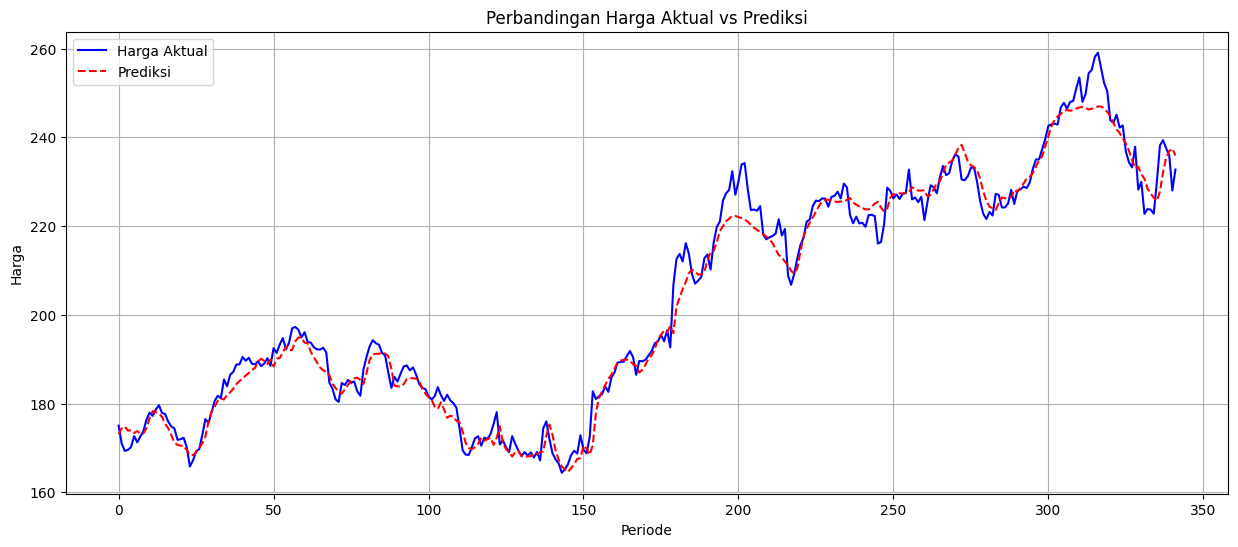

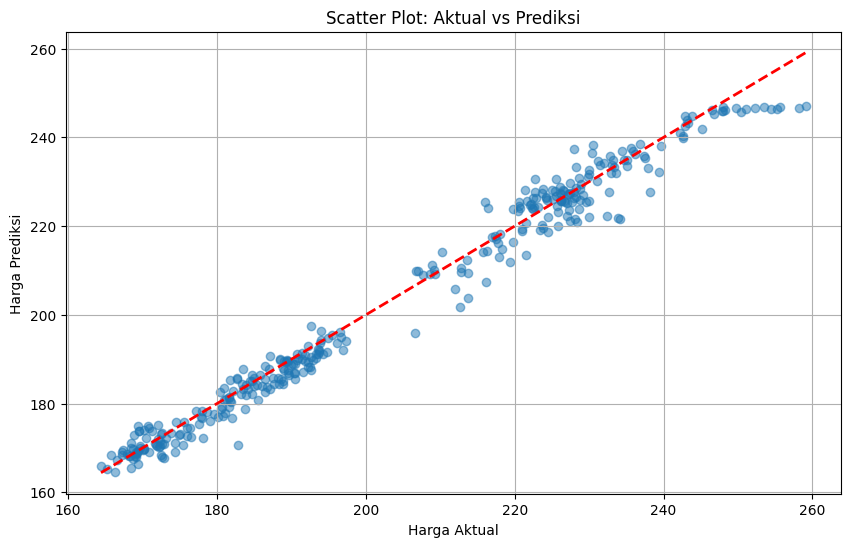

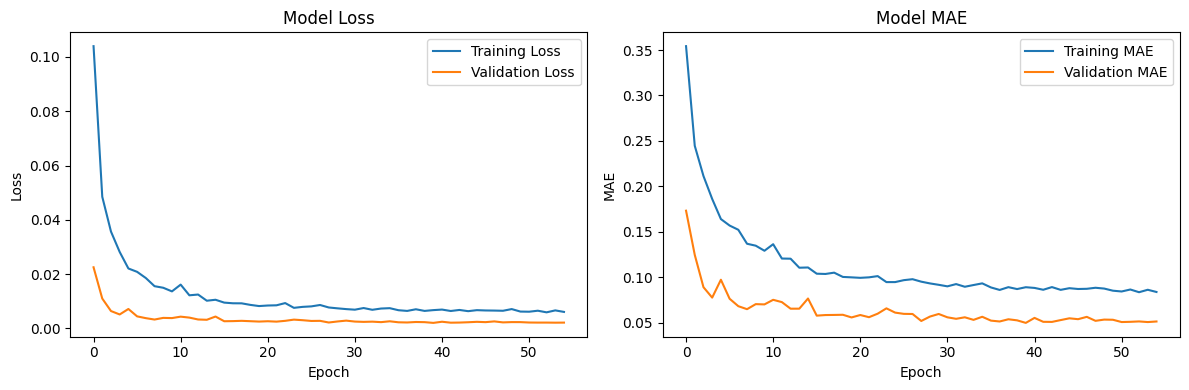

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


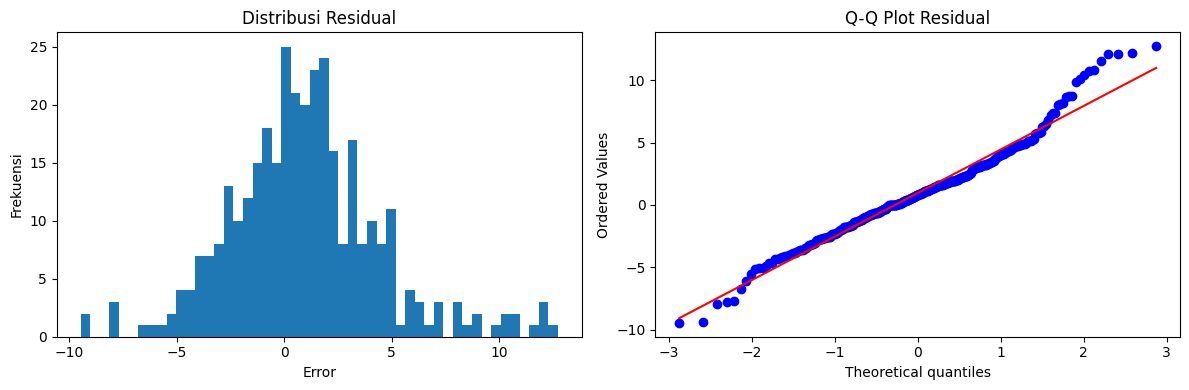


Interpretasi Hasil:
- Model dapat menjelaskan 97.99% variasi dalam data
- Rata-rata error absolut adalah 2.69 poin
- Error persentase rata-rata adalah 1.30%


In [35]:
# Evaluasi model 
def evaluate_model(model, X_test, y_test, price_scaler):
    # Prediksi
    y_pred = model.predict(X_test)
    
    # Inverse transform untuk mendapatkan nilai harga asli
    y_test_original = price_scaler.inverse_transform(y_test)
    y_pred_original = price_scaler.inverse_transform(y_pred)
    
    # Hitung berbagai metrik
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)
    
    # Hitung MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    
    print("\nHasil Evaluasi Model:")
    print(f"R-squared (R²) Score: {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    # Visualisasi hasil prediksi
    plt.figure(figsize=(15, 6))
    plt.plot(y_test_original, label='Harga Aktual', color='blue')
    plt.plot(y_pred_original, label='Prediksi', color='red', linestyle='--')
    plt.title('Perbandingan Harga Aktual vs Prediksi')
    plt.xlabel('Periode')
    plt.ylabel('Harga')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Plot scatter
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_original, y_pred_original, alpha=0.5)
    plt.plot([y_test_original.min(), y_test_original.max()], 
             [y_test_original.min(), y_test_original.max()], 
             'r--', lw=2)
    plt.xlabel('Harga Aktual')
    plt.ylabel('Harga Prediksi')
    plt.title('Scatter Plot: Aktual vs Prediksi')
    plt.grid(True)
    plt.show()
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluasi
metrics = evaluate_model(gru_model, X_test, y_test, price_scaler)

# Analisis residual
residuals = (price_scaler.inverse_transform(y_test) - 
            price_scaler.inverse_transform(gru_model.predict(X_test))).flatten()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50)
plt.title('Distribusi Residual')
plt.xlabel('Error')
plt.ylabel('Frekuensi')

plt.subplot(1, 2, 2)
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot Residual')

plt.tight_layout()
plt.show()

# Print interpretasi hasil
print("\nInterpretasi Hasil:")
print(f"- Model dapat menjelaskan {metrics['r2']*100:.2f}% variasi dalam data")
print(f"- Rata-rata error absolut adalah {metrics['mae']:.2f} poin")
print(f"- Error persentase rata-rata adalah {metrics['mape']:.2f}%")

In [36]:
# Fungsi untuk membuat prediksi baru
def predict_signal(data, rf_model, lstm_model, scaler):
    # Normalisasi data
    data_scaled = scaler.transform(data)
    
    # Prediksi dengan Random Forest
    rf_pred = rf_model.predict(data_scaled)
    
    # Prediksi dengan LSTM
    data_lstm = data_scaled.reshape((data_scaled.shape[0], 1, data_scaled.shape[1]))
    lstm_pred = lstm_model.predict(data_lstm)
    lstm_pred = np.argmax(lstm_pred, axis=1)
    
    # Gabungkan prediksi (ensemble)
    final_pred = []
    for rf, lstm in zip(rf_pred, lstm_pred):
        if rf == lstm:
            final_pred.append(rf)
        else:
            # Jika berbeda, gunakan prediksi Random Forest (karena lebih stabil sama lebih baik aja)
            final_pred.append(rf)
    
    # Konversi kembali ke label
    label_map = {0: 'Hold', 1: 'Buy', 2: 'Sell'}
    return [label_map[p] for p in final_pred]


In [37]:
latest_data = df[features].tail(10)
predictions = predict_signal(latest_data, rf_model, lstm_model, scaler)
print("\nPrediksi untuk 10 data terakhir:")
print(pd.DataFrame({
    'Tanggal': df['Date'][-10:],
    'Close': df['Close'].tail(10),
    'Prediksi': predictions
}))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

Prediksi untuk 10 data terakhir:
        Tanggal       Close Prediksi
1270 2025-01-22  223.830002     Hold
1271 2025-01-23  223.660004     Hold
1272 2025-01-24  222.779999     Hold
1273 2025-01-27  229.860001     Hold
1274 2025-01-28  238.259995     Hold
1275 2025-01-29  239.360001      Buy
1276 2025-01-30  237.589996     Hold
1277 2025-01-31  236.000000     Hold
1278 2025-02-03  228.009995     Hold
1279 2025-02-04  232.800003     Hold


In [38]:
import joblib

# Simpan model Random Forest
joblib.dump(rf_model, 'models/random_forest_model.joblib')
    
# Simpan model LSTM dengan custom_objects
lstm_model.save('models/lstm_model.h5', save_format='h5')
    
# Simpan model GRU dengan custom_objects
gru_model.save('models/gru_model.keras', save_format='keras')  
    
# Simpan semua scaler
joblib.dump(scaler, 'models/scaler.joblib')
joblib.dump(price_scaler, 'models/price_scaler.joblib')
joblib.dump(feature_scaler, 'models/feature_scaler.joblib')

['models/feature_scaler.joblib']